## 网格 tick 数据统计
- 每个tick价格变化的频率
- 每次tick的时间间隔
- heatmap

In [1]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from IPython.utils import io
from functions_processing_data import get_data
from helpful_scripts import f_change_barperiod
# from bt_grid import * 
from bt_grid_static import * 

In [67]:
# file_name = "binance_futures_BTCUSDT_20220329_tick.csv"
# file_name = "binance_futures_BTCUSDT_20220422_tick.csv"
# file_name = "binance_futures_XRPUSDT_20220405_tick.csv"

file_name = "BTCBUSD-trades-2022-04-21.csv"
# file_name = "ETHBUSD-trades-2022-04-21.csv"
# file_name = "XRPBUSD-trades-2022-04-21.csv"




if "BTC" in file_name:
    price_precision = 1
    tick_size = 0.1
elif "ETH" in file_name:
    price_precision = 2
    tick_size = 0.01
elif "XRP" in file_name:
    price_precision = 4
    tick_size = 0.0001

# tick_size = 0.1
# tick_size = 0.0001


data_path = os.path.join(os.getcwd(), "data")
df_data = pd.read_csv(
            os.path.join(data_path, file_name),
            names=["id", "close", "qty", "quoteQty", "time", "isBuyerMaker"]
        )
# df_data = pd.read_csv(
#             os.path.join(data_path, file_name), header=[0], index_col=[0]
#         )
df_data.set_index("time", inplace=True)
df_data.index = pd.to_datetime(df_data.index, unit="ms")
# df_data.rename(
#             columns={
#                 "Time": "time",
#                 "Open": "open",
#                 "High": "high",
#                 "Close": "close",
#                 "Low": "low",
#                 "Volume": "volume",
#                 "price": "close",
#             },
#             inplace=True,
#         )
df_data

,id,close,qty,quoteQty,isBuyerMaker
time,,,,,
2022-04-21 00:00:00.135,161371915,41345.8,0.002,82.6,True
2022-04-21 00:00:00.135,161371916,41345.8,0.002,82.6,True
2022-04-21 00:00:00.135,161371917,41345.8,0.001,41.3,True
2022-04-21 00:00:00.856,161371918,41345.2,0.013,537.4,True
2022-04-21 00:00:00.856,161371919,41345.2,0.001,41.3,True
...,...,...,...,...,...
2022-04-21 23:59:59.879,162108375,40463.3,0.003,121.3,False
2022-04-21 23:59:59.879,162108376,40463.3,0.026,1052.0,False
2022-04-21 23:59:59.879,162108377,40463.3,0.043,1739.9,False


### 每个tick价格变化的频率

In [68]:
df_data.loc[:, "dif_tick"] = np.round(df_data.close.diff() / tick_size)
lst_quantile = np.arange(0.1, 1, 0.1)
lst_quantile = np.append(lst_quantile,[0.95, 0.99, 0.999])
tick_change_quantile = df_data.dif_tick.abs().quantile(lst_quantile)
tick_change_quantile

0.100      0.0
0.200      0.0
0.300      0.0
0.400      0.0
0.500      0.0
0.600      0.0
0.700      1.0
0.800      1.0
0.900      5.0
0.950     10.0
0.990     30.0
0.999    118.0
Name: dif_tick, dtype: float64

### 每次tick的时间间隔的频率

In [69]:
# time to millseconds 
df_data.loc[:, "millseconds"] = df_data.index.view(np.int64) / int(1e6)

# difference in millseconds
df_data.loc[:, "d_millseconds"] = df_data.loc[:, "millseconds"].diff().round()

time_change_quantile = df_data.d_millseconds.abs().quantile(lst_quantile)
time_change_quantile


0.100       0.00
0.200       0.00
0.300       0.00
0.400       0.00
0.500       0.00
0.600       0.00
0.700       1.00
0.800      35.00
0.900     230.00
0.950     634.00
0.990    2197.00
0.999    6491.08
Name: d_millseconds, dtype: float64

In [70]:
# save 
df_frequency = pd.concat([tick_change_quantile, time_change_quantile], axis=1)
df_frequency.index = df_frequency.index * 100
df_frequency.to_excel(file_name.split(".csv")[0] + "_fq.xlsx")

In [72]:
df_frequency.rename(
    columns={"dif_tick": "每个tick的价格变化", "d_millseconds": "每个tick的时间变化"},
    inplace=True
)
df_frequency.columns

Index(['dif_tick', 'd_millseconds'], dtype='object')

In [73]:
# 三维图
df_data.loc[:, "abs_dif_tick"] = df_data.loc[:, "dif_tick"].abs()
df_data = df_data.loc[df_data.loc[:, "abs_dif_tick"]>0,:]
count = df_data.groupby(["abs_dif_tick","d_millseconds"]).count().close.reset_index()
count

,abs_dif_tick,d_millseconds,close
0,1.0,0.0,57313
1,1.0,1.0,1373
2,1.0,2.0,554
3,1.0,3.0,469
4,1.0,4.0,432
...,...,...,...
20009,1174.0,0.0,1
20010,1264.0,0.0,1
20011,1460.0,0.0,1
20012,1462.0,1.0,1


Text(0.5, 1.0, 'R1')

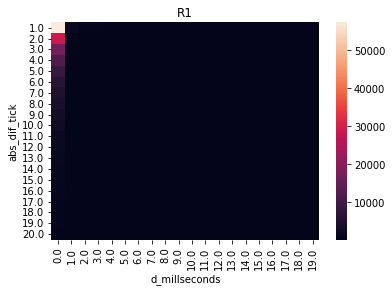

In [74]:
import seaborn as sns

piv = pd.pivot_table(
    count,
    values="close",
    index=["abs_dif_tick"],
    columns=["d_millseconds"],
    fill_value=0,
)
# piv.iloc[:100, :100]

plt.figure()
sns.heatmap(piv.iloc[:20, :20])
plt.title("R1")


Text(0.5, 1.0, 'R1')

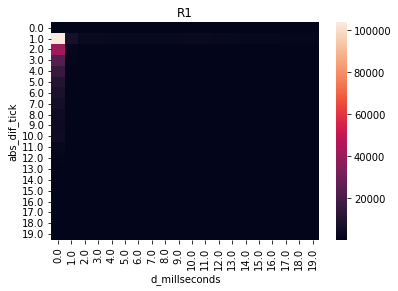

In [35]:
Z

array([[0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

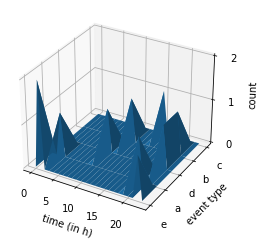

In [29]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np

#test data 
np.random.seed(123)
n = 10
start = pd.to_datetime("2021-04-21")
end = pd.to_datetime("2021-04-23")
n_minut = ((end - start).days + 1) * 24 * 60
date_range = pd.to_timedelta(np.random.randint(0, n_minut, n), unit="minute") + start
df = pd.DataFrame({"time": date_range, "event type": np.random.choice(list("abcde"), n)})

#count event types per hour
plot_df = df. groupby([df["time"].dt.hour, df["event type"]]).size().reset_index(name="event count")
#transcribe categorical data in column "event type" into integer values
#idx contains the list of event types according to their integer numbers
val, idx = plot_df["event type"].factorize()
plot_df["event_num"] = val

#generate evenly spaced x- and y-values
x_range = np.arange(24)
y_range = np.arange(idx.size)

#and create x-y arrays for the 3D plot
X, Y = np.meshgrid(x_range, y_range)
#and fill z-values with zeros
Z = np.zeros(X.shape)
#or the event count, if exists
Z[plot_df["event_num"], plot_df["time"]] = plot_df["event count"] 

#create figure with a 3D projection axis
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X, Y, Z)

ax.zaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_yticks(y_range, idx)
ax.set_ylabel("event type")
ax.set_xlabel("time (in h)")
ax.set_zlabel("count")

plt.show()

quantile 99 in seconds: 0.777
quantile 99.9 in seconds: 1.43200048828125


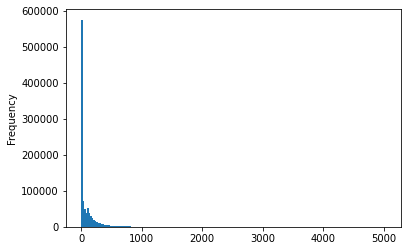

In [82]:
# tick 的时长分布
# pd.to_datetime(df_data.index, type='ms')

# time to millseconds 
df_data.loc[:, "millseconds"] = df_data.index.view(np.int64) / int(1e6)

# difference in millseconds
df_data.loc[:, "d_millseconds"] = df_data.loc[:, "millseconds"].diff()

# plot 
df_data.loc[:, "d_millseconds"].plot(kind = 'hist', bins = 200)

print(f"quantile 99 in seconds: {df_data.d_millseconds.quantile(0.99) /1000}")
print(f"quantile 99.9 in seconds: {df_data.d_millseconds.quantile(0.999) /1000}")

上下区间：
- 不会一瞬间跳出区间 [1s的价格变化 < 区间宽度] 
- 无线网格，其实一直在上下区间摆着的，只要有价格更新，就在上下区间摆单

In [91]:
# 1s bps变换
df_data_grouped = f_change_barperiod(df_data,"s")
df_data_grouped.loc[:, "pct_change_in_bps"] = df_data_grouped.loc[:, "close"].pct_change() * 10000

# 分布
print(f"95%: {df_data_grouped.pct_change_in_bps.abs().quantile(0.95)}")
print(f"99%: {df_data_grouped.pct_change_in_bps.abs().quantile(0.99)}")
print(f"99.9%: {df_data_grouped.pct_change_in_bps.abs().quantile(0.999)}")
print(f"99.999%: {df_data_grouped.pct_change_in_bps.abs().quantile(0.9999)}")
print(f"max: {df_data_grouped.pct_change_in_bps.abs().max()}")

# # 1s tick变换
# df_data_grouped = f_change_barperiod(df_data,"S")
# df_data_grouped.loc[:, "dif_tick"] = np.round(df_data_grouped.close.diff() / tick_size)

# # 分布
# print(f"95%: {df_data_grouped.dif_tick.abs().quantile(0.95)}")
# print(f"99%: {df_data_grouped.dif_tick.abs().quantile(0.99)}")
# print(f"99.9%: {df_data_grouped.dif_tick.abs().quantile(0.999)}")
# print(f"99.999%: {df_data_grouped.dif_tick.abs().quantile(0.9999)}")
# print(f"max: {df_data_grouped.dif_tick.abs().max()}")

95%: 1.5708075952537424
99%: 3.0488234984990075
99.9%: 6.386210900614823
99.999%: 15.87818783363715
max: 26.649721079445854


In [84]:
# file_name = "binance_futures_BTCUSDT_20200101_20220322.csv"
# df_data = get_data(file_name)
# df_data = df_data.loc[df_data.index > pd.to_datetime("2021/6/1"), :]

# # groupy by 1 hour 
# df_data_grouped = f_change_barperiod(df_data,"H")
# df_data_grouped.loc[:, "pct_change_in_bps"] = df_data_grouped.loc[:, "close"].pct_change()

# # 分布
# print(f"95%: {df_data_grouped.pct_change_in_bps.abs().quantile(0.95)}")
# print(f"99%: {df_data_grouped.pct_change_in_bps.abs().quantile(0.99)}")
# print(f"99.9%: {df_data_grouped.pct_change_in_bps.abs().quantile(0.999)}")
# print(f"99.999%: {df_data_grouped.pct_change_in_bps.abs().quantile(0.9999)}")

网格密度：
- 不能低于最小 ticksize （e.g., BTCUSDT 0.1,  XRPUSDT 0.0001）
- 在xx延迟情况下，网格密度 > 99%价格变化；或者网格密度 > 市价单的手续费。

In [92]:
# 
df_data_grouped = f_change_barperiod(df_data,"500ms")
df_data_grouped.loc[:, "dif_tick"] = np.round(df_data_grouped.close.diff() / tick_size)

# 分布
print(f"95%: {df_data_grouped.dif_tick.abs().quantile(0.95)}")
print(f"99%: {df_data_grouped.dif_tick.abs().quantile(0.99)}")
print(f"99.9%: {df_data_grouped.dif_tick.abs().quantile(0.999)}")
print(f"99.999%: {df_data_grouped.dif_tick.abs().quantile(0.9999)}")
print(f"max: {df_data_grouped.dif_tick.abs().max()}")

95%: 50.0
99%: 103.0
99.9%: 223.07600000003004
99.999%: 551.8455999998259
max: 1569.0


In [103]:
np.max(df_data_grouped.close.diff().abs())

154.8000000000029

In [105]:
# 
df_data_grouped = f_change_barperiod(df_data,"100ms")
df_data_grouped.loc[:, "dif_tick"] = np.round(df_data_grouped.close.diff() / tick_size)

# 分布
print(f"95%: {df_data_grouped.dif_tick.abs().quantile(0.95)}")
print(f"99%: {df_data_grouped.dif_tick.abs().quantile(0.99)}")
print(f"99.9%: {df_data_grouped.dif_tick.abs().quantile(0.999)}")
print(f"99.999%: {df_data_grouped.dif_tick.abs().quantile(0.9999)}")
print(f"max: {df_data_grouped.dif_tick.abs().max()}")

95%: 32.0
99%: 62.0
99.9%: 147.0
99.999%: 400.71799999964423
max: 1548.0
